In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import mesa_reader as ms
import pickle
import os
import seaborn as sns
import pandas as pd

In [2]:
class ModelData:
    
    def __init__(self, m, v, fov, profile):
        
        self.mass = m
        self.v = v
        self.fov = fov
        self.prof = profile
        self.chi = 1e99
        self.freq = []
        self.em = []
        self.ell = []

In [126]:
### run 1
# masses = [1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1]
# overshoot = [0,0.01,0.02, 0.03,0.04]
# velocity = [200,215,230,245,260,275,290,300]
# # run1 = ""

### run 2
# masses = [1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3]
# overshoot = [0.05, 0.06, 0.07]
# velocity = [200,215,230,245,260,275,290]
# run2 = "more"

### run 3
masses = [2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7]
# # # masses = [2.2,2.3,2.4,2.5,2.6,2.7]
overshoot = [0.06, 0.07,0.08] #0.04,0.05,
velocity = [185,190,200,210,220,230,240,250]

# masses = [2.1,2.2,2.3,2.4,2.5]
# overshoot = [0.05, 0.06, 0.07,0.08]
# velocity = [185,190,200,210,220,230, 240, 250]

ObsFreqs = np.sort([3.6376896, 6.29998, 4.816594665, 6.39246, 5.93023, 5.237989, 3.736297])
#only 3 g modes among first 10 freq
# ObsFreqs = np.sort([1.52138, 1.062249, 0.76008])  
# ObsFreqs = np.sort([3.6376896])

In [127]:
def chigrid(m,CheckBestValue=False, nad = False):
    chilist = []
    ModelFits = []
    ModelFitspd = []
    # for m in masses:
    for fov in overshoot:
        for v in velocity:
            bestchiprofile = 30
    #         print('hi')
            directory = '../mesafolder/work/LOGS/M'+str(m)+'_alpha'+str(fov)+'_v'+str(v)
#             flist = glob.glob(directory + "/nonrad1frequencies*_split.txt")
            flist = glob.glob(directory + "/nonrad2frequencies*_split.txt")
#             flist = glob.glob(directory + "allmodefrequenciessept*_nad.txt")
#             flist = glob.glob(directory + "gmodefrequenciessept*_split.txt")
#             flist = glob.glob(directory + "/nonrad1frequencies*_nad.txt")
#             flist = glob.glob(directory + "/lowgfrequencies*_nad.txt")
            
    #         print(directory,flist)
            for f in flist:
                profile = f.split('_')
#                 if profile[3] == 'split':
#                 if profile[3] == 'nad.txt':
#                     print(profile[3])
#                     continue
#                 print(profile[3])
                profile = profile[2].split('s')[1]
#                 print(profile)
                ModFileName = directory+"/profile"+str(profile)+".data"

                Model = ModelData(m,v,fov,profile)
                star = ms.MesaData(ModFileName)


                # read frequency data
                FreqFile = open(f)
                data = np.loadtxt(FreqFile, skiprows=6)
                FreqFile.close()
                if data.ndim < 2:
                    continue
                    
                Model.mass = data[0,1]
                radius = data[0,2]
                #split
                if nad ==False:
                    ell = data[:,5]
                    em = data[:,6] 
                    ModelFreqs = data[:,3]
                if nad == True:
                #nad
                    ell = data[:,7]
                    em = data[:,8]
                    ModelFreqs = data[:,5]
                    ModelGrowth = data[:,4]

    
            #pos, intrinsically excited, negative is damped
                #no model growth
                # get mass and radius for scaling

#                 scalefactor = np.sqrt(6.672e-8 * Model.mass / (radius)**3) / (2 * np.pi)
    #                 ModelFreqs = ModelFreqs * scalefactor * 86400 # put frequencies in c/d

                # find differences in model vs observed frequencies:
                chiSquare = 0
                Model.ell = np.zeros(len(ObsFreqs))
                Model.em = np.zeros(len(ObsFreqs))
                Model.freqs = np.zeros(len(ObsFreqs))
#                 print(ModelFreqs)
                i = 0
                if nad == True:
                    if len(ModelFreqs[ModelGrowth>0]) < 1:
                        continue
                else:
                    if len(ModelFreqs) < 1:
                        continue
                for freq in ObsFreqs:
                    if nad ==True:
                        bestIndex = np.argmin(np.abs(freq-ModelFreqs[ModelGrowth>0]))
                    else:
                        bestIndex = np.argmin(np.abs(freq-ModelFreqs))
                    chiSquare +=(freq - ModelFreqs[bestIndex])**2
                    Model.ell[i] = ell[bestIndex]
                    Model.em[i] = em[bestIndex]
                    Model.freqs[i] = ModelFreqs[bestIndex]

                    i = i + 1

                chiSquare = chiSquare/len(ObsFreqs)
                if chiSquare < Model.chi:
                    Model.chi = chiSquare
#                     print(Model.chi)
                ModelFits.append(Model)
                ModelFitspd.append([Model.mass/1.989e33, Model.v, Model.fov, int(Model.prof), round(Model.chi, 3)])
            # making list of chi values in order
                if Model.chi < bestchiprofile:
                    bestchiprofile = Model.chi
            chilist.append(bestchiprofile)    
        
    
    #checking the BestFit
    BestFit = ModelData(1,1,1,1)
    #compares to that model, then to every model after
    for m in ModelFits:
        if m.chi < BestFit.chi:
            BestFit = m
    if CheckBestValue == True:
        print(BestFit.mass/1.989e33, BestFit.v, BestFit.fov, BestFit.prof, BestFit.chi)
    #make chi array
    chiarray = np.empty((len(overshoot),len(velocity)))
    index = 0
    for i in range(len(overshoot)):
        for j in range(len(velocity)):
            chiarray[i][j] = chilist[index]
            index +=1  
    #print(Model.freqs)
    return chiarray#, chilist, ModelFitspd

### if 'local variable 'Model' referenced before assignment', files didn't get written OR 

In [108]:
for m in masses:    
    print(chigrid(m,CheckBestValue=False))
#run3
#2.599204329605598 200 0.08 20 0.003603327144859232

[[10.68975316 10.3703818  10.04181772  9.56565658  9.3759612   8.87060623
   8.51314211 30.        ]
 [10.67134488 10.37044811  9.94866518  9.41259646  9.36846715  8.93251735
   8.3917834  30.        ]
 [10.8100865  10.55081996  9.89049189  9.39772931  9.08122703  9.02863023
   8.40558815 30.        ]
 [10.69927078 10.5973254  10.31730356  9.28950301  8.94016395  8.96835648
   8.34448606 30.        ]
 [10.71420544 10.524076   10.32527929  9.36353199  9.03133107  9.03169273
   8.48772606 30.        ]]
[[30.         30.         10.03355722  9.7552098   9.07681087  9.08476579
   8.6850526  30.        ]
 [30.         30.         10.11655947  9.46663564  9.32376237  9.08828103
   8.45673899 30.        ]
 [30.         30.         10.24642715  9.51869961  9.30320801  8.64592985
   8.60671429 30.        ]
 [30.         30.         10.15223669  9.51959291  9.21971537  8.65222653
   8.54562311 30.        ]
 [30.         30.         10.11362871  9.53142685  9.31323678  8.66249085
   8.59356387 30

In [12]:
print(chigrid(2.2,CheckBestValue=True))

2.1993284152606907 220 0.05 8 0.2561224500362163
[[ 0.71937587  0.7733878   0.28864387  0.90716429  0.25612245  0.92203858
  30.         30.        ]
 [ 0.96611323  0.39732473  0.38281254  0.89204533  0.38231533  0.83605506
  30.         30.        ]
 [ 0.68774859  0.40600194  0.39811539  0.99567342  0.94920045  0.90093673
  30.         30.        ]
 [ 1.01501778  0.9957265   0.90348343  0.89634053  0.88414142  0.86765986
  30.         30.        ]]


In [11]:
#adiabatic
print(chigrid(2.1,CheckBestValue=True))
print(chigrid(2.2,CheckBestValue=True))
print(chigrid(2.3,CheckBestValue=True))
print(chigrid(2.4,CheckBestValue=True))
print(chigrid(2.5,CheckBestValue=True))
### failed often... why are all the chis so low?

2.0993602682250807 210 0.08 6 3.652951176134445
[[3.65563374 3.65723419 3.65439743 3.66025662 3.66276837 3.68505573
  3.6728471  3.70380126]
 [3.66414224 3.65396909 3.6714306  3.65348877 3.65948959 3.66646286
  3.65455504 3.6847507 ]
 [3.67239468 3.65990245 3.65921793 3.6845596  3.66509598 3.67379485
  3.65446143 3.6546753 ]
 [3.65666282 3.66269074 3.66203981 3.65853033 3.67405574 3.66506256
  3.66751565 3.65416922]
 [3.66267154 3.66076266 3.65326566 3.65295118 3.66453923 3.67604689
  3.67888021 3.66121509]]
2.1993284152606907 210 0.04 3 3.65293419056213
[[3.6607111  3.65864098 3.67123233 3.65293419 3.69837641 3.66491323
  3.67785844 3.66442191]
 [3.69784363 3.663593   3.65322122 3.65473408 3.65594123 3.6625371
  3.65465264 3.65312965]
 [3.66037487 3.66914379 3.65541243 3.71065859 3.65405136 3.65358125
  3.65934008 3.67182605]
 [3.65499761 3.66862091 3.68998743 3.68703129 3.69484609 3.70057836
  3.68880258 3.65299505]
 [3.65380962 3.66891517 3.6678811  3.66392344 3.65353369 3.66101639


In [44]:
print("$M_{\odot}$")

$M_{\odot}$


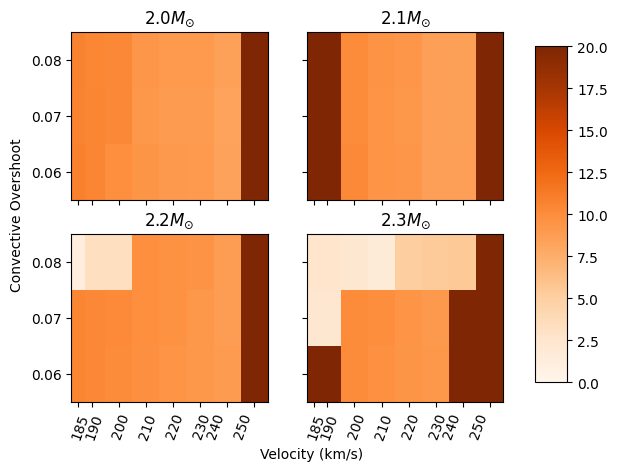

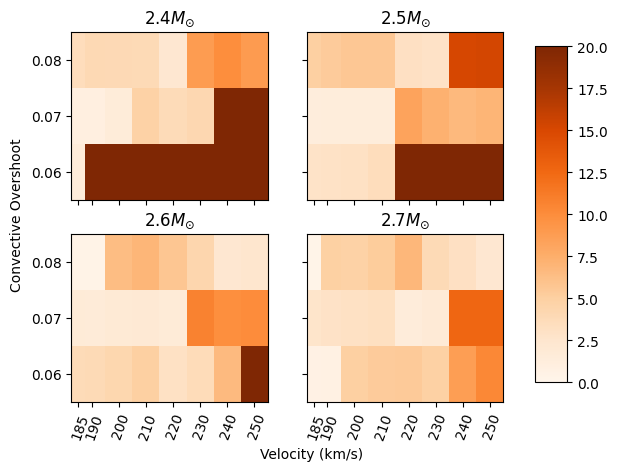

In [130]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
vminimum = 0
vmaximum = 20
colmap = "Oranges"
# plt.xlabel('Velocity (km/s)')
# plt.ylabel('Convective Overshoot')
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# plt.xticks(velocity)
plt.setp(axs[0,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[0,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.xticks(velocity)
plt.yticks(overshoot)
im1 = axs[0,0].pcolormesh(velocity, overshoot, chigrid(masses[0]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,0].title.set_text(str(masses[0])+"$M_{\odot}$")
im2 = axs[0,1].pcolormesh(velocity, overshoot, chigrid(masses[1]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,1].title.set_text(str(masses[1])+"$M_{\odot}$")
im3 = axs[1,0].pcolormesh(velocity, overshoot, chigrid(masses[2]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[1,0].title.set_text(str(masses[2])+"$M_{\odot}$")
im4 = axs[1,1].pcolormesh(velocity, overshoot, chigrid(masses[3]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[1,1].title.set_text(str(masses[3])+"$M_{\odot}$")
fig.subplots_adjust(right=0.8)
fig.text(0.5, 0.001, 'Velocity (km/s)', ha='center', va='center')
fig.text(0.04, 0.5, 'Convective Overshoot', ha='center', va='center', rotation='vertical')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)

plt.savefig("omeerichis1.png", bbox_inches = 'tight', dpi =600)

fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
plt.xticks(velocity)
plt.yticks(overshoot)
plt.setp(axs[0,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[0,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
im1 = axs[0,0].pcolormesh(velocity, overshoot, chigrid(masses[4]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,0].title.set_text(str(masses[4])+"$M_{\odot}$")
# plt.xlabel('Virial mass ($10^{14} M_{\odot}$)',fontsize=14)
im2 = axs[0,1].pcolormesh(velocity, overshoot, chigrid(masses[5]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[0,1].title.set_text(str(masses[5])+"$M_{\odot}$")
im3 = axs[1,0].pcolormesh(velocity, overshoot, chigrid(masses[6]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[1,0].title.set_text(str(masses[6])+"$M_{\odot}$")
im4 = axs[1,1].pcolormesh(velocity, overshoot, chigrid(masses[7]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[1,1].title.set_text(str(masses[7])+"$M_{\odot}$")
fig.subplots_adjust(right=0.8)
fig.text(0.5, 0.001, 'Velocity (km/s)', ha='center', va='center')
fig.text(0.04, 0.5, 'Convective Overshoot', ha='center', va='center', rotation='vertical')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)
plt.savefig("omeerichis2.png", bbox_inches = 'tight', dpi =600)

### failed often... why are all the chis so low?

In [ ]:
plt.xlabel('Velocities')
plt.ylabel('Convective Overshoot')
plt.pcolormesh(velocity, overshoot, chigrid(2.2), cmap="Greens", shading = 'nearest')
plt.colorbar()
plt.title("$\u03C7^2$ grid")

6518.191044428765
4.133382518465426
1084399663.8085377


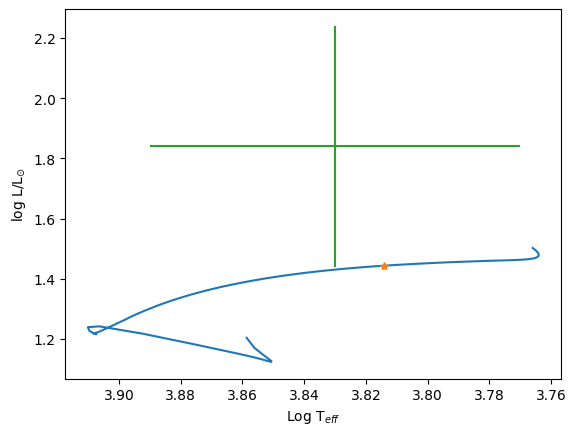

<Figure size 640x480 with 0 Axes>

In [32]:
bestfitdir = "../mesafolder/work/LOGS/M2.1_alpha0.04_v200/"
star = ms.MesaData(str(bestfitdir + "history.data"))
Teff = star.data('log_Teff')
L = star.data('log_L')
plt.figure()
plt.plot(Teff,L)
#star2 = ms.MesaData("LOGS/Z02Models/M9.2_alpha0.01_v50/history.data")
#plt.plot(star2.data('log_Teff'),star2.data('log_L'),'--')
# modnum = 70
modnum = 70
plt.plot(star.data_at_model_number('log_Teff',modnum),star.data_at_model_number('log_L',modnum),'*')
print(10**star.data_at_model_number('log_Teff',modnum))
print(10**star.data_at_model_number('log_R',modnum))
print(star.data_at_model_number('star_age',modnum))
# plt.errorbar(4.3,3.5,xerr=0.06, yerr=0.4)
# plt.errorbar(3.83,1.84,xerr=2.31, yerr=0.4)
# expect 
plt.errorbar(3.83,1.84,xerr=0.06, yerr=0.4)
plt.gca().invert_xaxis()
plt.xlabel("Log T$_{eff}$")
plt.ylabel("log L/L$_{\odot}$")
plt.show()
plt.savefig("/Users/skbowes/research/jup/plots")

In [73]:
#check best chi value overall
ModelFits = []
for m in masses:
    for fov in overshoot:
        for v in velocity:
            directory = '../mesafolder/work/LOGS/M'+str(m)+'_alpha'+str(fov)+'_v'+str(v)
            flist = glob.glob(directory + "/morefrequencies*_split.txt")
            #print(directory,flist)
            for f in flist:
                profile = f.split('_')
                if profile[3] == 'split':
                    continue
                profile = profile[2].split('s')[1]
                ModFileName = directory+"/profile"+str(profile)+".data"
                
                Model = ModelData(m,v,fov,profile)
                
                star = ms.MesaData(ModFileName)

                
                # read frequency data
                FreqFile = open(f)
                data = np.loadtxt(FreqFile, skiprows=6)
                FreqFile.close()
                if data.ndim < 2:
                    continue
                
                Model.mass = data[0,1]
                radius = data[0,2]
                    
                ell = data[:,2]
                em = data[:,3]
#                 n = data[:,4]
                ModelFreqs = data[:,7]
                ModelGrowth = data[:,9]
                # get mass and radius for scaling
                
                scalefactor = np.sqrt(6.672e-8 * Model.mass / (radius)**3) / (2 * np.pi)
#                 ModelFreqs = ModelFreqs * scalefactor * 86400 # put frequencies in c/d
                
                # find differences in model vs observed frequencies:
                chiSquare = 0
                Model.ell = np.zeros(len(ObsFreqs))
                Model.em = np.zeros(len(ObsFreqs))
                Model.freqs = np.zeros(len(ObsFreqs))
                i = 0
                if len(ModelFreqs[ModelGrowth>0]) < 1:
                    continue
                for freq in ObsFreqs:
                    
                    bestIndex = np.argmin(np.abs(freq-ModelFreqs[ModelGrowth>0]))
                    
                    chiSquare +=(freq - ModelFreqs[bestIndex])**2
                    Model.ell[i] = ell[bestIndex]
                    Model.em[i] = em[bestIndex]
                    Model.freqs[i] = ModelFreqs[bestIndex]
                    
                    i = i + 1
                    
                chiSquare = chiSquare/len(ObsFreqs)
                if chiSquare < Model.chi:
                    Model.chi = chiSquare
                ModelFits.append(Model)
                
print(len(ModelFits))
BestFit = ModelData(1,1,1,1)
    #compares to that model, then to every model after
for m in ModelFits:
    if m.chi < BestFit.chi:
        BestFit = m
print(BestFit.mass/1.989e33, BestFit.v, BestFit.fov, BestFit.prof, BestFit.chi)

0
5.027652086475616e-34 1 1 1 1e+99


In [33]:
#create columns
overshootlist = []
velocitylist = []
for i in range(len(overshoot)):
    for j in range(len(velocity)):
        velocitylist.append(velocity[j])
for k in range(len(overshoot)):
    for n in range(len(velocity)):
        overshootlist.append(overshoot[k])

In [37]:
sample = chigrid(2.1)[1]
ModelFits1 = chigrid(2.1)[2]

In [83]:
ModelFitspd = chigrid(2.1)
#make pandas dataframe
# df = pd.DataFrame([velocitylist,overshootlist,sample], index=['vel', 'fov', 'chi'])
df = pd.DataFrame(ModelFitspd[2], columns = ['mass', 'velocity', 'overshoot', 'profile', 'chi'])

In [84]:
df

,mass,velocity,overshoot,profile,chi
0,2.09936,200,0.00,3,0.111
1,2.09936,200,0.00,11,0.111
2,2.09936,200,0.00,8,0.882
3,2.09936,200,0.00,2,1.340
4,2.09936,200,0.00,10,0.111
...,...,...,...,...,...
418,2.09936,290,0.04,4,0.111
419,2.09936,290,0.04,9,0.111
420,2.09936,290,0.04,1,0.111
421,2.09936,290,0.04,7,0.792


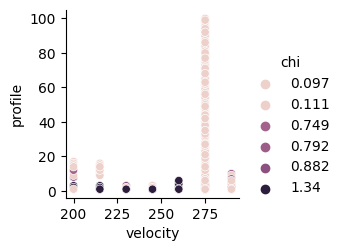

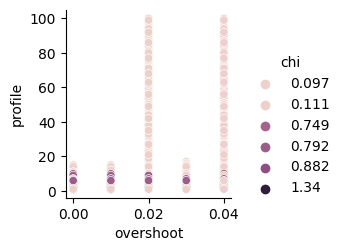

In [92]:
sns.pairplot(df, hue = 'chi', x_vars='velocity', y_vars='profile')
# check what overshoot this is 
sns.pairplot(df, hue = 'chi', x_vars='overshoot', y_vars='profile')

In [ ]:
data2 = np.loadtxt(bestfitdir + "frequencies15_nad.txt",skiprows=6)
plt.figure()
plt.plot(data2[:,7],data2[:,9],'o')
#plt.plot(nonad2[:,7],nonad2[:,9],'d')
plt.plot(ObsFreqs,0.1 * np.ones(len(ObsFreqs)),'x')
plt.grid()
plt.xlabel("Frequency (c/d)")
plt.ylabel("$\eta$")

In [ ]:
print(BestFit.freqs)
print(BestFit.ell)
print(BestFit.em)
print(ObsFreqs)